In [1]:
# 2018-10-12
# A. Pendleton
# Parsing the BLATs of the high scoring, non-redundant de novo genes from Zoey2.3
#    against CanFam3.1 to identify which are novel to Zoey, or already partially/fully
#    captured in the CanFam3.1 assembly
# Then, these are linked to the BLAST2GO 

In [2]:
#this uses iPython magic to make plots appear inline
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import sys
import numpy as np
import matplotlib.patches as patches
import gzip
import fileinput
import glob
from scipy import stats
import re
from matplotlib_venn import venn3, venn3_circles
from collections import OrderedDict


def count_lines(f):
    lineCount = 0
    with open(f, 'r') as f:
        for line in f:
            lineCount += 1
        return lineCount
def runCMD(cmd):
    val = subprocess.Popen(cmd, shell=True).wait()
    if val == 0:
        pass
    else:
        print ('command failed')
        print (cmd)
        sys.exit(1)
# TO REMOVE TOP AND RIGHT AXIS OF PLOTS
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
#Write PBS Script
def write_pbs_file(wkDir,cmdsFile,jobName, mem, jobCount):
    #write PBS file
    if '/scripts/' in wkDir:
        wkDir = wkDir.replace('/scripts/','')
    pbsFile = open(cmdsFile.replace('.cmds','.pbs'),'w')
    print('Writing pbs file: %s'% pbsFile)
    pbsFile.write('#!/bin/bash\n')
    pbsFile.write('#PBS -S /bin/bash\n')
    pbsFile.write('#PBS -V\n')
    pbsFile.write('#PBS -M ampend@med.umich.edu\n')
    pbsFile.write('#PBS -j oe\n')
    pbsFile.write('#PBS -N %s\n' % jobName)
    pbsFile.write('#PBS -o %s\n' % (wkDir + 'logs/'))
    pbsFile.write('#PBS -l pmem=%iG\n' % mem)
    pbsFile.write('#PBS -l nodes=1:ppn=1,qos=flux,walltime=100:00:00\n')
    pbsFile.write('##PBS -A medbsm_flux\n')
    pbsFile.write('##PBS -q flux\n')
    pbsFile.write('#PBS -A jmkidd_fluxod\n')
    pbsFile.write('#PBS -q fluxod\n')
    pbsFile.write('#PBS -t 1-%s\n' % jobCount)
    pbsFile.write('cd %s\n' % (wkDir))
    pbsFile.write('/home/ampend/links/kidd-lab/jmkidd-projects/scripts/perlUtils/run-by-id-log.pl %s %sBLAT_commands.logs $PBS_ARRAYID' % (cmdsFile,cmdsFile.replace('/scripts/','/logs/')))
    pbsFile.close()

In [3]:
# Final Gene directory to keep the parsed gene model information
finalDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/'

# Create dictionary with ALL gene models as keys

In [4]:
v3Linkv2File = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/LinkToVersion2Models/Link_Version3Genes_Version2Genes.txt'

v3Dict,v2Dict = {},{}
for line in open(v3Linkv2File,'r'):
    line=line.rstrip().split('\t')
    if 'v' in line[0]: #skip header
        continue

    #v3,v2 = line[0].split('::')[1],line[1].split('::')[1]
    v3,v2 = line[0], line[1]
    """if v3 == v2:
        continue"""
    v3Dict[v3] = v2
    v2Dict[v2] = v3

In [5]:
skipFile = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/NonRedundant_NoRMIntersect_FilteredGeneSet/../Pseudogene_Search/skip_these_models_fullyWithinOthers.txt'
skippedGenes = []

for line in open(skipFile,'r'):
    line=line.rstrip()
    shortID = line.split('::')[1]
    longID = line
    #skippedGenes.append(shortID)
    skippedGenes.append(longID)

print('%i single exon genes were skipped because they were redundant and overlapped with another single exon gene' % len(skippedGenes))

########################################################################################
totalGeneFile = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/NonRedundant_NoRMIntersect_FilteredGeneSet/TotalSet_NoRMSingleExons_AllMultiExons_cds.fa'

geneDict = {}
geneList = []

stillWrong = []
for line in open(totalGeneFile,'r'):
    if '>' not in line: #only want identifer
        continue
    line=line.rstrip().replace('>','')
    longID = line
    shortID = line.split('::')[1]
    
    #if shortID in skippedGenes:
    if longID in skippedGenes:
        continue
    if longID in v2Dict.keys() and longID not in v3Dict.keys():
        stillWrong.append(longID)

    #geneDict[shortID] = []
    #geneList.append(shortID)
    geneDict[longID] = []
    geneList.append(longID)

print('%i gene models added to dictionary' % len(geneList))
print('** Therefore, final gene count is %i genes **' % len(geneList))

print('%i may be v2 names -- wrong?' % len(stillWrong))
print('stil wrong?', stillWrong )


2532 single exon genes were skipped because they were redundant and overlapped with another single exon gene
42911 gene models added to dictionary
** Therefore, final gene count is 42911 genes **
0 may be v2 names -- wrong?
stil wrong? []


# GET ZOEY COORDINATES FOR ALL GENE MODELS

In [6]:
#geneBed = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/NonRedundant_NoRMIntersect_FilteredGeneSet/input/HighestScoringTranscripts_IDs.bed'
#geneBed = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/transdecoder/results/HighestScoringTranscripts_IDs.bed'
geneBed = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/HighestScoringTranscripts_IDs.bed'
zoeyCoordDict = {}
newBed = open(finalDir + 'Zoey_FinalGenes.12.bed', 'w')
count = 0

for LINE in open(geneBed,'r'):
    line=LINE.rstrip().split('\t')
    shortID = line[3].split('::')[1]
    longID = line[3].replace('ID=','').split(';')[0]

    #We only want the genes that passed all of our subsequent filtration, so make sure each gene 
    #   is in our geneList array
    #if shortID not in geneList:
    if longID not in geneList:
        continue
    zoey_chrom, zoey_start, zoey_end, zoey_strand = line[0], line[1], line[2], line[5]
    
    #zoeyCoordDict[shortID] = [zoey_chrom,zoey_start,zoey_end, zoey_strand,longGeneID]
    zoeyCoordDict[longID] = [zoey_chrom,zoey_start,zoey_end, zoey_strand,longID,shortID]
    
    #write all of this out to bedfile
    newBed.write('%s' % LINE)
    count += 1

    
print('Added %i gene coordinates to dictionary and output file' % count)
print('Matches number of keys in dict: len(zoeyCoordDict.keys()):', len(zoeyCoordDict.keys()))
newBed.close()    
    

Added 42911 gene coordinates to dictionary and output file
Matches number of keys in dict: len(zoeyCoordDict.keys()): 42911


# Generate Fastas for Final Genes!

### Make ID file just for the final genes

In [7]:
IDfile = finalDir + 'FinalGenes_IDs.txt'
IDFile = open(IDfile,'w')
count = 0

for gene in zoeyCoordDict.keys():
    longID = zoeyCoordDict[gene][4].split(';')[0]
    count+=1
    IDFile.write('%s\n' % longID)

IDFile.close()
print('Wrote the IDs of %i genes to: %s' % (count,IDfile))

Wrote the IDs of 42911 genes to: /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/FinalGenes_IDs.txt


### Pull out FASTA with samtools faidx

In [8]:
### In earlier scripts the transdecoder .pep and .cds fasta files were already indexed

##################################################################################
# PEPTIDE
v3Dir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/'

pepFasta = v3Dir + 'pasa-lite_ZoeyTrinity.pasa_assembled_alignments.fa.transdecoder.pep'
pep_outFasta = finalDir + 'Zoey_FinalGenes.pep.fa'

cmd = 'xargs samtools faidx %s < %s > %s' % (pepFasta,IDfile,pep_outFasta)
print(cmd)
#runCMD(cmd)

cmd = 'samtools faidx %s' % pep_outFasta
print(cmd)
#runCMD(cmd)

##################################################################################
#CDS
cdsFasta = v3Dir + 'pasa-lite_ZoeyTrinity.pasa_assembled_alignments.fa.transdecoder.cds'
cds_outFasta = finalDir + 'Zoey_FinalGenes.cds.fa'

cmd = 'xargs samtools faidx %s < %s > %s' % (cdsFasta,IDfile,cds_outFasta)
print(cmd)
#runCMD(cmd)

cmd = 'samtools faidx %s' % cds_outFasta
print(cmd)
#runCMD(cmd)

xargs samtools faidx /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/pasa-lite_ZoeyTrinity.pasa_assembled_alignments.fa.transdecoder.pep < /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/FinalGenes_IDs.txt > /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/Zoey_FinalGenes.pep.fa
samtools faidx /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/Zoey_FinalGenes.pep.fa
xargs samtools faidx /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/pasa-lite_ZoeyTrinity.pasa_assembled_alignments.fa.transdecoder.cds < /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/FinalGenes_IDs.txt > /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/Zoey_FinalGenes.cds.fa
samtools faidx /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_G

# SPLIT Final Gene Fastas


In [9]:
splitDir = finalDir + 'split_fastas/'
cmd = 'mkdir -p %s' % splitDir
print(cmd)
#runCMD(cmd)

cmd = 'cd %s' % splitDir
print(cmd)
#runCMD(cmd)

cmd = 'awk \'BEGIN {n_seq=0;} /^>/ {if(n_seq%%10000==0){file=sprintf(\"%ssplit_cds_%%d.fa\",n_seq);} print >> file; n_seq++; next;} { print >> file; }\' < %s' % (splitDir,cds_outFasta)  
print(cmd)
#runCMD(cmd)
#*Note: sometimes this doesn't run, may need to copy+paste the below command into command 
#line within the split_fastas directory to run this

mkdir -p /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/split_fastas/
cd /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/split_fastas/
awk 'BEGIN {n_seq=0;} /^>/ {if(n_seq%10000==0){file=sprintf("/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/split_fastas/split_cds_%d.fa",n_seq);} print >> file; n_seq++; next;} { print >> file; }' < /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/Zoey_FinalGenes.cds.fa


# BLAT TO CANFAM3


### Make blat output directory

In [10]:
blatDir = finalDir + 'BLAT_to_Canfam/'
cmd = 'mkdir -p %s' % blatDir
print(cmd)
runCMD(cmd)


mkdir -p /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/BLAT_to_Canfam/


### Make blat output directory

In [11]:
#oocFile = '/home/ampend/links/kidd-lab/ampend-projects/annotations_genes/11.ooc'
oocFile = '/home/ampend/links/kidd-lab/genomes/canFam3.1/canFam3.1-cat/11.ooc'
CF3_2bit = '/home/ampend/links/kidd-lab/genomes/canFam3.1/canFam3.1-withUn/canFam3.1.withUn.fa.2bit'

cmdfile = blatDir + 'cf3_blat_commands.cmds'
cmdFile = open(cmdfile,'w')
jobCount = 0
for file in glob.glob(splitDir + '*fa'):
    splitNum = file.replace(splitDir,'').replace('.fa','')
    pslOut = blatDir + splitNum + '.psl'

    cmd = 'blat -out=psl -ooc=%s -tileSize=11 -noHead ' % (oocFile)
    cmd+= '%s ' % CF3_2bit
    cmd+= '%s %s ' % (file,pslOut)
    print(cmd)
    cmdFile.write('%s\n' % cmd)
    jobCount+=1
    
cmdFile.close()

write_pbs_file(blatDir,cmdfile,'cf3BLAT', 10, jobCount)


blat -out=psl -ooc=/home/ampend/links/kidd-lab/genomes/canFam3.1/canFam3.1-cat/11.ooc -tileSize=11 -noHead /home/ampend/links/kidd-lab/genomes/canFam3.1/canFam3.1-withUn/canFam3.1.withUn.fa.2bit /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/split_fastas/split_cds_0.fa /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/BLAT_to_Canfam/split_cds_0.psl 
blat -out=psl -ooc=/home/ampend/links/kidd-lab/genomes/canFam3.1/canFam3.1-cat/11.ooc -tileSize=11 -noHead /home/ampend/links/kidd-lab/genomes/canFam3.1/canFam3.1-withUn/canFam3.1.withUn.fa.2bit /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/split_fastas/split_cds_20000.fa /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/BLAT_to_Canfam/split_cds_20000.psl 
blat -out=psl -ooc=/home/ampend/links/kidd-lab/genomes/canFam3.1/canFam3.1-cat/11.ooc -tileSize=11 -noHead /home/ampend/links/kidd-lab/genomes/canFam3.1/canFam3.1-withUn/canFam3.

### Reading in the BLAT results against CanFam

In [12]:
#Where the BLAT results are located:
blatDict = {} #To store all of the results from the BLATs


#The gene sequences were split into multiple subsets to make the BLAT faster. 
#Read each blat output file (*psl) in with a loop
for file in glob.glob(blatDir + '*psl'):
    for line in open(file,'r'):
        line=line.rstrip().split()
        hitLength, orient, chrom, start, end = int(line[0]),line[8],line[13],int(line[14]),int(line[15])
        
        #gene information
        longID, shortID = line[9], line[9].split('::')[1]
        geneLength = int(line[10])
        
        #alignment blocks
        blockLengths = line[-3].split(',')
        blockSumLength = 0
        for b in range(0,len(blockLengths)-1):
            blockSumLength = blockSumLength + int(blockLengths[b])
   
        #Calculate the proportion of the hit as the sum of the blocks that align
        propHit = float(blockSumLength)/geneLength
        #What type of hit is it? Full/Partial/No hit
        if propHit >= 0.9:
            hitType = 'Full'
        if propHit >= float(1/3) and propHit < 0.9:
            hitType = 'Partial'
        #Skip the genes that are not aligning with at least a third of their length
        if propHit < float(1/3):
            hitType = 'No hit'
            continue
        
        #Add to dictionary if not in there
        if longID not in blatDict.keys():
            blatDict[longID] = ['',propHit,chrom,start,end,shortID,orient,hitType,line]
            blatDict[longID][0] = []
            #Save first hit automatically as the best hit
            topPropHit = propHit
        
        #Keep track of all proportion of hits
        blatDict[longID][0].append(propHit)

        #Save it all to a dictionary
        if propHit > topPropHit:
            #Redefine the top hit (topPropHit) as propHit's value since it's now a better alignment
            topPropHit = propHit
            blatDict[longID][1] = propHit
            blatDict[longID][2] = chrom
            blatDict[longID][3] = start
            blatDict[longID][4] = end
            blatDict[longID][5] = shortID
            blatDict[longID][6] = orient
            blatDict[longID][7] = hitType
            blatDict[longID][8] = line
    
    
print('Added %i genes to dictionary that at least partially hit (>1/3 of length)' % (len(blatDict.keys())))
print('Done')    

Added 42207 genes to dictionary that at least partially hit (>1/3 of length)
Done


# BLAST2GO
#### Now that we have read all of the BLAT results into a dictionary. 
#### We next need to read in the BLAST2GO Data to link genes-function

In [13]:
#blast2GODir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/BLAST2GO/BLAST2GO_Results/MERGED_Total/'
blast2GODir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/BLAST2GO/BLAST2GO_Results/'

#b2Gofile = blast2GODir + 'Total_BLAST2GO_table.txt'
#b2Gofile = blast2GODir + 'FINAL_BLAST2GO_Zoey_Table.txt'
b2Gofile = blast2GODir + 'October2018/FINAL_subsets1234_Table.txt'

b2GoDict = {}
count = 0
noblast,blastonly,maponly,annotated = 0, 0, 0, 0
MISSING = []

for line in open(b2Gofile,'r'):
    if 'Tags' in line: #Skips header
        continue
    line=line.rstrip().split('\t')#split line by tab
    count +=1 
    #Long ID
    ID = line[2]

    #Short ID - which may be different if scaffold or blat is in geneID 
    if 'scaffold' not in ID and 'blat' not in ID and 'TCONS' not in ID:
        shortID = ID.split('_')[1]
        longID = ID.replace('_','::')

    if 'scaffold' in ID or 'blat' in ID or 'TCONS' in ID:
        shortID = line[2].split('_')[1] + '_' + line[2].split('_')[2]
        longID = ID.replace('_','::').replace('chain::','chain_').replace('TCONS::','TCONS_').replace('scaffold::','scaffold_')

    
    #Create empty dictionary entry for each and every gene no matter what
    if longID in b2GoDict.keys():
        print('\t\tWhy is this gene already in dictionary - is there a dupe?:\n\t\t%s' % longID)
        continue
        
    if longID in v2Dict.keys() and longID not in v3Dict.keys() and longID not in skippedGenes:
        print('Switching to v3 ID for: ', longID)
        longID = v2Dict[longID]
    
    if longID in skippedGenes:
        continue
    #b2GoDict[shortID] = {}
    b2GoDict[longID] = {}
        
    #Column 2 details if the gene has been BLASTED/MAPPED/ANNOTATED
    #NO BLAST HIT:
    if 'NO-BLAST' in line[1]:
        status = 'No BLAST Hit'
        noblast+=1
        #b2GoDict[shortID] = [status, '',int(line[4]),'','','','','','', '']  
        b2GoDict[longID] = [status, '',int(line[4]),'','','','','','', '']  
        continue
    
    #ONLY WILL HAVE INFORMATION ABOUT TOP BLAST HIT, NO ANNOTATION INFO
    hitDesc, length, hitCount, evalue, sim_mean = line[3], int(line[4]), int(line[5]), line[6], float(line[7]), 

    if 'BLASTED' in line[1] and 'MAPPED' not in line[1] and 'ANNOTATED' not in line[1]:
        status = 'BLAST only'
        GOs, GODesc = '', ''
        blastonly+=1
    
    #WILL HAVE GO INFORMATION FOR THOSE CLASSIFIED AS HAVING BEEN MAPPED AND/OR ANNOTATED
    if 'BLASTED' in line[1] and 'MAPPED' in line[1] and 'ANNOTATED' not in line[1]:
        status = 'Putative'
        maponly +=1
        GOs, GODesc = line[9], line[10]
    if 'ANNOTATED' in line[1]:
        status = 'Annotated'
        GOs, GODesc = line[9], line[10]
        annotated+=1
        
    #Add the enzyme code information for lines that HAVE that information
    if 'EC:' in line:
        EC, ECDesc = line[9], line[10]
    else:
        EC, ECDesc = '', ''
    
    
    #CREATE DICTIONARY TO STORE ALL THIS
    #b2GoDict[shortID] = [status, hitDesc,length,hitCount,evalue,sim_mean,GOs,GODesc,EC, ECDesc]
    b2GoDict[longID] = [status, hitDesc,length,hitCount,evalue,sim_mean,GOs,GODesc,EC, ECDesc]

    
print('Added %i BLAST2GO genes into b2GoDict' % len(b2GoDict.keys()))
print('No BLAST count = ',noblast)
print('BLAST only count = ',blastonly)
print('Mapped only count = ',maponly)
print('Annotated only count = ',annotated)
print('Sum === %i' % (noblast+blastonly+maponly+annotated))




Added 42911 BLAST2GO genes into b2GoDict
No BLAST count =  18217
BLAST only count =  2843
Mapped only count =  1962
Annotated only count =  19889
Sum === 42911


# Kalisto
### Incorporation of expression quantification data

In [14]:
kalDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/Kalisto/'
resultsDir = kalDir + 'results/'

samplesProcessed = []
for files in glob.glob(resultsDir + 'SRR*'):
    samplesProcessed.append(files.replace(resultsDir,''))
    
print('%i samples processed through Kallisto' % len(samplesProcessed))

42 samples processed through Kallisto


In [15]:
#CALCULATE STATS AND DRAW PLOTS PER SAMPLE
sampleCount = 0

tpmDict = {}

for sample in samplesProcessed:
    tpms = [] #clear per sample
    sampleCount += 1
    
    inFile = resultsDir + sample + '/' + 'abundance.tsv'
    for line in open(inFile,'r'):
        if 'target_id' in line:
            continue
        line=line.rstrip().split('\t')
        longID = line[0]
        shortID = line[0].split('::')[1]
        tpm = float(line[4])

        #if only the first sample, create key for the gene
        if sampleCount == 1:
            #0 = library expression TPMs, Pass/Fail CD-Hit
            #tpmDict[shortID] = [[],'Fail','','','','']
            tpmDict[longID] = [[],'Fail','','','','']
        #If expressed at tpm > 1, add to dictionary
        if tpm > 1.0:
            #tpmDict[shortID][0].append(tpm) #add TPM to total dictionary      
            tpmDict[longID][0].append(tpm) #add TPM to total dictionary      
        tpms.append(tpm) #add TPM to per saple array for stats (below)
print('%i samples processed' % sampleCount)

42 samples processed


## Gene Names --> Gene Symbols
#### BLAST2GO  PRO output a GFF file that can be parsed to get the gene symbols

In [16]:
#gffFile = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/BLAST2GO/BLAST2GO_Results/MERGED_Total/Total_BLAST2GO.gff'
#gffFile = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/BLAST2GO/BLAST2GO_Results/MERGED_Total/FINAL_BLAST2GO_Zoey_Annotations_GFF.gff'
#gffFile = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/BLAST2GO/BLAST2GO_Results/MERGED_BLAST2GO_Zoey_GFF3.gff'
gffFile = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/BLAST2GO/BLAST2GO_Results/October2018/FINAL_subsets1234_GFF.gff'

symbolDict = {}
count = 0

for line in open(gffFile,'r'):
    if '#' in line: #skip header
        continue
    line=line.rstrip().split('\t')
    
    ID = line[0]
    info = line[8].split(';')

    #Renaming gene since BLAST2GO converted all _ in ID to ::
    if 'scaffold' not in ID and 'blat' not in ID and 'TCONS' not in ID:
        shortID = ID.split('_')[1]
        longID = ID.replace('_','::')
    if 'scaffold' in ID or 'blat' in ID or 'TCONS' in ID:
        shortID = ID.split('_')[1] + '_' + ID.split('_')[2]
        longID = ID.replace('_','::').replace('chain::','chain_').replace('TCONS::','TCONS_').replace('scaffold::','scaffold_')
    
    
    #Check if we should go by the V3 id and not the V2 id
    if longID in v2Dict.keys() and longID not in v3Dict.keys() and longID not in skippedGenes:
        print('Switching to v3 ID for: ', longID)
        longID = v2Dict[longID]

    #Check to see if it's already a key
    if longID in symbolDict.keys():
        print('Why already in here?:', longID)
        continue
    #symbolDict[shortID] = []
    symbolDict[longID] = []
    geneSymbol = shortID #default
    count += 1
   
    
    #Search the GFF info line if there is a gene Symbol
    for i in range(2,len(info)):
        if 'Gene=' in info[i]:
            geneSymbol = info[i].split('=')[1]#.replace('"','')
            if '_' in geneSymbol: #these are mostly hypothetical proteins in the other species
                continue
            #Make all letters upper-case
            geneSymbol = geneSymbol.upper()
            
            #Eliminate those that are not specific. Will add them back if there's nothing else
            if 'LOC' in geneSymbol:
                continue
            if 'A0A' in geneSymbol: #there may be other top gene Symbols you want to look at first
                continue
            if 'DKFZ' in geneSymbol:
                continue
            #These are uniprot IDs
            if len(geneSymbol) == 6:
                if geneSymbol[0].isalpha() is True:
                    if geneSymbol[0].isdigit() is True:
                        print(geneSymbol)
                        sys.exit()
                        continue
            
            #if geneSymbol in symbolDict[shortID]: #Dont add if it's already in there 
            if geneSymbol in symbolDict[longID]: #Dont add if it's already in there 
                continue
            #symbolDict[shortID].append(geneSymbol)
            symbolDict[longID].append(geneSymbol)

    #if len(symbolDict[shortID]) == 0:
    if len(symbolDict[longID]) == 0:
        if geneSymbol != shortID: #If there was something else from the loop above, just go with this instead of the generic gene ID
            #symbolDict[shortID].append(geneSymbol) #even if it has a _ in the name
            symbolDict[longID].append(geneSymbol) #even if it has a _ in the name
            continue
        else: #If no other symbols were available for this locus, then just name the gene the last gene Symbol given to the gene
            geneSymbol = shortID
            #symbolDict[shortID].append(geneSymbol)
            symbolDict[longID].append(geneSymbol)

    #For testing:
    """if len(symbolDict.keys()) > 29:
        break"""
print('Processed %i genes...' % count)
print('Added %i annotated genes with their gene symbols to symbolDict' % len(symbolDict.keys()))


Processed 45443 genes...
Added 45443 annotated genes with their gene symbols to symbolDict


## BLAST2GO Interpro Annotations

In [17]:
interproDict = {}

"""interproFile = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/BLAST2GO/BLAST2GO_Results/MERGED_Total/' + 'Final_InterproOnly_Table.txt'

count = 0

for line in open(interproFile,'r'):
    if 'Tags' in line: #skip header
        continue
    line=line.rstrip().split('\t')
    count+=1
    a
    #Get the shortened vague gene model identifiers
    shortID = line[2].split('_')[1] #shortened gene ID
    if 'scaffold' in line[2] or 'blat' in line[2]:
        shortID = line[2].split('_')[1] + '_' + line[2].split('_')[2]
    
    interproInfo = line[13]
    interproGOIDs = line[14]
    interproGODesc = line[15]
    #Save the above information to dictionary of interpro data
    interproDict[shortID] = [interproInfo,interproGOIDs,interproGODesc]

    
print('Processed Interpro data for %i genes... ' % count)
"""

"interproFile = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/BLAST2GO/BLAST2GO_Results/MERGED_Total/' + 'Final_InterproOnly_Table.txt'\n\ncount = 0\n\nfor line in open(interproFile,'r'):\n    if 'Tags' in line: #skip header\n        continue\n    line=line.rstrip().split('\t')\n    count+=1\n    a\n    #Get the shortened vague gene model identifiers\n    shortID = line[2].split('_')[1] #shortened gene ID\n    if 'scaffold' in line[2] or 'blat' in line[2]:\n        shortID = line[2].split('_')[1] + '_' + line[2].split('_')[2]\n    \n    interproInfo = line[13]\n    interproGOIDs = line[14]\n    interproGODesc = line[15]\n    #Save the above information to dictionary of interpro data\n    interproDict[shortID] = [interproInfo,interproGOIDs,interproGODesc]\n\n    \nprint('Processed Interpro data for %i genes... ' % count)\n"

# Integrate the Mapping Data, Novelty Status (hits to CanFam), and Annotations (BLAST2GO) into one large datafile

In [18]:
geneDict = {}

for gene in geneList:
    geneDict[gene] = {}
      
    #Get Zoey coordinates for gene
    if gene in zoeyCoordDict.keys():
        geneDict[gene]['Zoey_Chrom'] = zoeyCoordDict[gene][0]
        geneDict[gene]['Zoey_Start'] = zoeyCoordDict[gene][1]
        geneDict[gene]['Zoey_End'] = zoeyCoordDict[gene][2]
        geneDict[gene]['Zoey_Strand'] = zoeyCoordDict[gene][3]
        geneDict[gene]['Zoey_LongGeneID'] = zoeyCoordDict[gene][4]
    else:
        print('ERROR CHECK: Why is this not in Zoeys dictionary?')
    
    #Get CANFAM BLAT INFORMATION
    if gene in blatDict.keys():
        geneDict[gene]['FullGeneID'] = blatDict[gene][5]
        geneDict[gene]['CanFam_AlignmentStatus'] = blatDict[gene][7]
        geneDict[gene]['CanFam_Chrom'] = blatDict[gene][2]
        geneDict[gene]['CanFam_Start'] = blatDict[gene][3]
        geneDict[gene]['CanFam_End'] = blatDict[gene][4]
        geneDict[gene]['CanFam_PropAlign'] = blatDict[gene][1]
        geneDict[gene]['CanFam_Strand'] = blatDict[gene][2]
    else:
        geneDict[gene]['FullGeneID'] = ''
        geneDict[gene]['CanFam_AlignmentStatus'] = 'No hit'
        geneDict[gene]['CanFam_Chrom'] = ''
        geneDict[gene]['CanFam_Start'] = ''
        geneDict[gene]['CanFam_End'] = ''
        geneDict[gene]['CanFam_PropAlign'] = ''
        geneDict[gene]['CanFam_Strand'] = ''      
    
    #Get Annotation information, if available
    if gene in b2GoDict.keys():
        #b2GoDict[shortID] = [status, hitDesc,length,hitCount,evalue,sim_mean,GOs,GODesc,EC, ECDesc]
        geneDict[gene]['B2GO_Status'] = b2GoDict[gene][0]
        geneDict[gene]['B2GO_TopHitDesc'] = b2GoDict[gene][1]
        geneDict[gene]['GeneLength'] = b2GoDict[gene][2]
        geneDict[gene]['B2GO_HitCount'] = b2GoDict[gene][3]
        geneDict[gene]['B2GO_HitEvalue'] = b2GoDict[gene][4]
        geneDict[gene]['B2GO_MeanHitSimilarity'] = b2GoDict[gene][5]
        geneDict[gene]['B2GO_GOs'] = b2GoDict[gene][6]
        geneDict[gene]['B2GO_GOsDesc'] = b2GoDict[gene][7]
        geneDict[gene]['B2GO_EnzymeCode'] = b2GoDict[gene][8]
        geneDict[gene]['B2GO_EnzymeCodeDesc'] = b2GoDict[gene][9]
    else:
        geneDict[gene]['B2GO_Status'] = ''
        geneDict[gene]['B2GO_TopHitDesc'] = ''
        geneDict[gene]['GeneLength'] = ''
        geneDict[gene]['B2GO_HitCount'] = ''
        geneDict[gene]['B2GO_HitEvalue'] = ''
        geneDict[gene]['B2GO_MeanHitSimilarity'] = ''
        geneDict[gene]['B2GO_GOs'] = ''
        geneDict[gene]['B2GO_GOsDesc'] = ''
        geneDict[gene]['B2GO_EnzymeCode'] = ''
        geneDict[gene]['B2GO_EnzymeCodeDesc'] = ''        

    #EXPRESSION DATA = KALISTO
    libraryCount = 0
    for i in tpmDict[gene][0]:
        if i > 1:
            libraryCount += 1
    geneDict[gene]['Kalisto_LibrariesExpression'] = libraryCount
    if libraryCount > 1:
        geneDict[gene]['Kalisto_ExpressionStatus'] = 'Expressed'
    else:
        geneDict[gene]['Kalisto_ExpressionStatus'] = 'Not Expressed'
    
    #GENE SYMBOLS = BLAST2GO GFF OUTPUT FILE
    if gene in symbolDict.keys():
        geneDict[gene]['B2GO_GeneSymbol'] = ', '.join(symbolDict[gene])
    else:
        geneDict[gene]['B2GO_GeneSymbol'] = gene

    #INTERPRO DOMAIN INFORMATION
    if gene in interproDict.keys():
        geneDict[gene]['Interpro_Domains'] = interproDict[gene][0]
        geneDict[gene]['Interpro_GOs'] = interproDict[gene][0]
        geneDict[gene]['Interpro_GOsDesc'] = interproDict[gene][0]
    else:
        #****CHANGE ONCE WE GET INTERPRO ANNOTATIONS COMPLETE***
        geneDict[gene]['Interpro_Domains'] = ''
        geneDict[gene]['Interpro_GOs'] = ''
        geneDict[gene]['Interpro_GOsDesc'] = ''
        #print('Why is this gene not in the interpro dict?: %s' % gene)
        #sys.exit()



print('Added %i genes to the final, total dictionary (geneDict) ' % len(geneDict.keys()))
    


Added 42911 genes to the final, total dictionary (geneDict) 


#### Write the dictionary to an outfile with header line

In [19]:
#dataOrder = ['Zoey_LongGeneID','Zoey_Chrom','Zoey_Start','Zoey_End','Zoey_Strand','GeneLength',
#            'CanFam_AlignmentStatus','CanFam_Chrom','CanFam_Start','CanFam_End','CanFam_Strand','CanFam_PropAlign',
#            'B2GO_Status','B2GO_GeneSymbol','B2GO_TopHitDesc','B2GO_HitCount','B2GO_HitEvalue','B2GO_MeanHitSimilarity',
#            'B2GO_GOs','B2GO_GOsDesc','B2GO_EnzymeCode','B2GO_EnzymeCodeDesc',
#            'Interpro_Domains','Interpro_GOs','Interpro_GOsDesc',
#            'Kalisto_ExpressionStatus','Kalisto_LibrariesExpression']
dataOrder = ['Zoey_LongGeneID','Zoey_Chrom','Zoey_Start','Zoey_End','Zoey_Strand','GeneLength',
            'CanFam_AlignmentStatus','CanFam_Chrom','CanFam_Start','CanFam_End','CanFam_Strand','CanFam_PropAlign',
            'B2GO_Status','B2GO_GeneSymbol','B2GO_TopHitDesc','B2GO_HitCount','B2GO_HitEvalue','B2GO_MeanHitSimilarity',
            'B2GO_GOs','B2GO_GOsDesc','B2GO_EnzymeCode','B2GO_EnzymeCodeDesc',
            'Kalisto_ExpressionStatus','Kalisto_LibrariesExpression']


#OUTFILE:
geneOutfile = open(finalDir + 'FinalDeNovoGenes_ZoeyCoord_CanfamCoord_BLAST2GO.txt','w')

#What are the headers for each column? Use array above
headerLine = []
headerLine.append('ShortGeneID')
for dataColumn in dataOrder:
    headerLine.append(dataColumn)
geneOutfile.write('\t'.join(headerLine) + '\n')
    
for gene in geneDict.keys():
    data = []
    data.append(gene)
    for dataColumn in dataOrder:
        data.append(str(geneDict[gene][dataColumn]))
    geneOutfile.write('\t'.join(data) + '\n')
    
geneOutfile.close()

In [100]:
################################################################################################
################################################################################################

### Integrate the gene models into the final BED file for UCSC

In [20]:
inBed = finalDir + 'Zoey_FinalGenes.12.bed'

outbed = finalDir + 'Zoey_FinalGenes_GeneSymbols.12.bed'
outBed = open(outbed,'w')

count = 0
for line in open(inBed,'r'):
    count+=1
    line=line.rstrip().split()
    newLine = line
    
    #gene = line[3].split('::')[1]
    gene = line[3].split(';')[0]
    
    #simply replace the old gene name with the gene symbol or shortened gene model name
    
    #for genes with multiple options, we are going to want to choose the 
    # one that is best descriptive for the gene. Sometimes it's a uniprot or interpro
    # id that BLAST2GO gives, but if we see that there's another option we will want 
    # to choose that one. 
    #To detect a UniProt gene, it typically starts with a letter then a digit, and is 
    #  always six characters long. I've written a loop to go through all possible
    #  symbols per gene and only if there is another option will it use the uniprot ID
    if gene not in symbolDict.keys():
        print('Not in symbolDict, why? :',gene)
        break
    
    if len(symbolDict[gene]) > 1:
        
        #finalSymbol = ''
        for i in range(0,len(symbolDict[gene])):
            symbol = symbolDict[gene][i]
            if 'ORF' in symbol: #Those are positional orfs, not uniprot ids
                continue
            #Pattern for finding the uniprot IDs
            if len(symbol) == 6 and symbol[0].isalpha() is True and symbol[1].isdigit() is True:
                continue
            
            else:
                finalSymbol = symbol
                
                finalSymbol = finalSymbol.replace(' ','_')

    else: #if no other options, we have what we have
        finalSymbol = symbolDict[gene][0]
        finalSymbol = finalSymbol.replace(' ','_')
        
    newLine[3] = finalSymbol

    """if count > 100: #for testing
        break"""
    outBed.write('\t'.join(newLine) + '\n')
outBed.close()


print('Wrote out bed file coordinates for %i genes' % count)

Wrote out bed file coordinates for 42911 genes


#### Sorting and making into UCSC file

In [21]:
#sort bedfile
cmd = 'bedSort %s %s' % (outbed,outbed.replace('.bed','.sorted.bed'))
print(cmd)
runCMD(cmd)

chromSizeFile = '/home/ampend/links/kidd-lab/genomes/zoey/assemblies/2.3/ref/zoey.2.3.chrom.sizes'
cmd = 'bedToBigBed %s %s %s -bedFields=9' % (outbed.replace('.bed','.sorted.bed'),chromSizeFile,outbed.replace('.bed','.bb'))
print(cmd)
runCMD(cmd)



bedSort /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/Zoey_FinalGenes_GeneSymbols.12.bed /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/Zoey_FinalGenes_GeneSymbols.12.sorted.bed
bedToBigBed /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/Zoey_FinalGenes_GeneSymbols.12.sorted.bed /home/ampend/links/kidd-lab/genomes/zoey/assemblies/2.3/ref/zoey.2.3.chrom.sizes /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/Zoey_FinalGenes_GeneSymbols.12.bb -bedFields=9


In [100]:
################################################################################################
################################################################################################

# Descriptive Stats

### ALL GENES

count sum = (NoHit, Partials, Hits) (704, 1613, 40594)


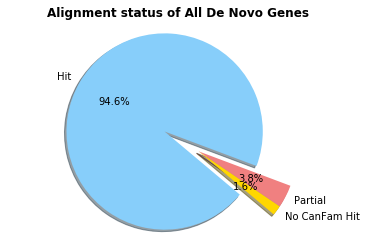

In [22]:
# BLAT TO CANFAM
NoHit, Partials, Hits = 0,0,0
for gene in geneDict.keys():    
    if geneDict[gene]['CanFam_AlignmentStatus'] == 'No hit':
        NoHit += 1
        continue
    if geneDict[gene]['CanFam_AlignmentStatus'] == 'Partial':
        Partials += 1
        continue
    if geneDict[gene]['CanFam_AlignmentStatus'] == 'Full':
        Hits += 1
        continue

    else:
        print('ERROR: What else is there?')
        print(gene,geneDict[gene])
print('count sum = (NoHit, Partials, Hits)', (NoHit, Partials, Hits))

#Make pie chart
labels = 'No CanFam Hit', 'Partial', 'Hit'
sizes = [NoHit, Partials, Hits]
colors = ['gold', 'lightcoral', 'lightskyblue']
explode = (0, 0, 0.4)  # explode 1st slice
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=320)
plt.title('Alignment status of All De Novo Genes', fontweight='bold') 
plt.axis('equal')
plt.show()

count sum =  42911
No BLAST =  18217
BLAST Only =  2843
Mapped Only =  1962
Fully Annotated =  19889


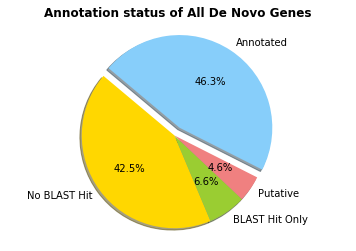

In [23]:
#BLAST2GO
NoB2GO, BlastOnly, MappedOnly, Annotated = 0,0,0,0
for gene in geneDict.keys():
    if geneDict[gene]['B2GO_Status'] == 'No BLAST Hit':
        NoB2GO += 1
        continue
    if geneDict[gene]['B2GO_Status'] == 'BLAST only':
        BlastOnly += 1
        continue
    if geneDict[gene]['B2GO_Status'] == 'Putative':
        MappedOnly += 1
        continue
    if geneDict[gene]['B2GO_Status'] == 'Annotated':
        Annotated += 1
        continue
    else:
        print('ERROR: What else is there?')
        print(gene,geneDict[gene])
print('count sum = ', (NoB2GO + BlastOnly + MappedOnly+ Annotated))
print('No BLAST = ',NoB2GO)
print('BLAST Only = ',BlastOnly)
print('Mapped Only = ',MappedOnly)
print('Fully Annotated = ',Annotated)
    
#Make pie chart
labels = 'No BLAST Hit', 'BLAST Hit Only', 'Putative', 'Annotated'
sizes = [NoB2GO, BlastOnly, MappedOnly, Annotated]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0, 0, 0, 0.1)  # explode 4th slice
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Annotation status of All De Novo Genes', fontweight='bold') 
plt.axis('equal')
plt.show()

In [24]:
#BLAST2GO
NoB2GO_len, BlastOnly_len, MappedOnly_len, Annotated_len = [],[],[],[]
for gene in geneDict.keys():
    if geneDict[gene]['B2GO_Status'] == 'No BLAST Hit':
        NoB2GO_len.append(geneDict[gene]['GeneLength'])
        continue
    if geneDict[gene]['B2GO_Status'] == 'BLAST only':
        BlastOnly_len.append(geneDict[gene]['GeneLength'])
        continue
    if geneDict[gene]['B2GO_Status'] == 'Putative':
        MappedOnly_len.append(geneDict[gene]['GeneLength'])
        continue
    if geneDict[gene]['B2GO_Status'] == 'Annotated':
        Annotated_len.append(geneDict[gene]['GeneLength'])
        continue
    else:
        print('ERROR: What else is there?')
        print(gene,geneDict[gene])

print('__NO BLAST__')
print('Min gene length = ', min(NoB2GO_len))
print('Max gene length = ', max(NoB2GO_len))
print('Mean gene length = ', np.mean(NoB2GO_len))
print('Median gene length = ', np.median(NoB2GO_len))
print('__ANNOTATED__')
print('Min gene length = ', min(Annotated_len))
print('Max gene length = ', max(Annotated_len))
print('Mean gene length = ', np.mean(Annotated_len))
print('Median gene length = ', np.median(Annotated_len))

__NO BLAST__
Min gene length =  85
Max gene length =  734
Mean gene length =  130.694241642
Median gene length =  118.0
__ANNOTATED__
Min gene length =  85
Max gene length =  10563
Mean gene length =  455.855296898
Median gene length =  339.0


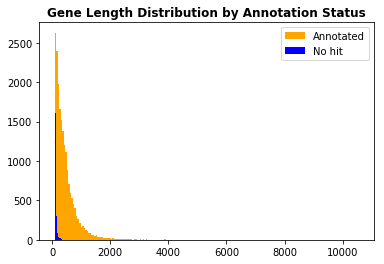

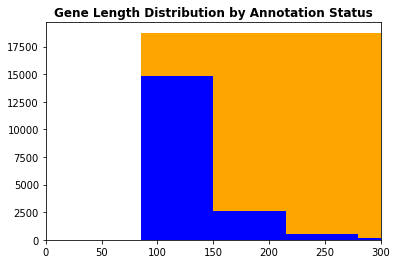

In [25]:
# Plot
plt.hist(Annotated_len, bins = 200, color = 'orange', label='Annotated')
_ = plt.hist(NoB2GO_len, bins = 200, color = 'blue',label='No hit')
plt.legend()
plt.title('Gene Length Distribution by Annotation Status', fontweight='bold') 
plt.show()


#__ZOOMED__
_ = plt.hist(Annotated_len, color = 'orange')
_ = plt.hist(NoB2GO_len, color = 'blue')
plt.xlim(0,300)
plt.title('Gene Length Distribution by Annotation Status', fontweight='bold') 
plt.show()

count sum =  17950
No BLAST =  1029
BLAST Only =  1399
Mapped Only =  1042
Fully Annotated =  14480


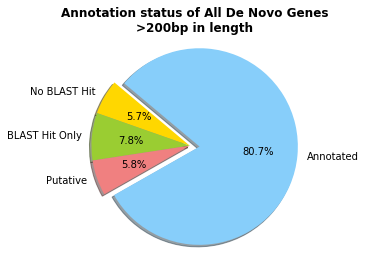

In [26]:
#BLAST2GO
NoB2GO, BlastOnly, MappedOnly, Annotated = 0,0,0,0
for gene in geneDict.keys():
    if geneDict[gene]['GeneLength'] < 200:
        continue
    if geneDict[gene]['B2GO_Status'] == 'No BLAST Hit':
        NoB2GO += 1
        continue
    if geneDict[gene]['B2GO_Status'] == 'BLAST only':
        BlastOnly += 1
        continue
    if geneDict[gene]['B2GO_Status'] == 'Putative':
        MappedOnly += 1
        continue
    if geneDict[gene]['B2GO_Status'] == 'Annotated':
        Annotated += 1
        continue
    else:
        print('ERROR: What else is there?')
        print(gene,geneDict[gene])
print('count sum = ', (NoB2GO + BlastOnly + MappedOnly+ Annotated))
print('No BLAST = ',NoB2GO)
print('BLAST Only = ',BlastOnly)
print('Mapped Only = ',MappedOnly)
print('Fully Annotated = ',Annotated)
    
#Make pie chart
labels = 'No BLAST Hit', 'BLAST Hit Only', 'Putative', 'Annotated'
sizes = [NoB2GO, BlastOnly, MappedOnly, Annotated]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0, 0, 0, 0.1)  # explode 4th slice
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Annotation status of All De Novo Genes\n>200bp in length', fontweight='bold') 
plt.axis('equal')
plt.show()

count sum =  25033
No BLAST =  17208
BLAST Only =  1448
Mapped Only =  923
Fully Annotated =  5454


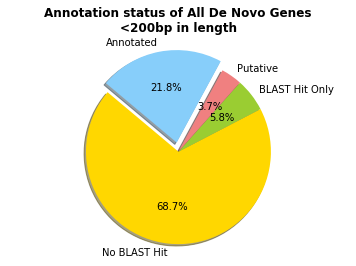

In [27]:
#BLAST2GO
NoB2GO, BlastOnly, MappedOnly, Annotated = 0,0,0,0
for gene in geneDict.keys():
    if geneDict[gene]['GeneLength'] > 200:
        continue
    if geneDict[gene]['B2GO_Status'] == 'No BLAST Hit':
        NoB2GO += 1
        continue
    if geneDict[gene]['B2GO_Status'] == 'BLAST only':
        BlastOnly += 1
        continue
    if geneDict[gene]['B2GO_Status'] == 'Putative':
        MappedOnly += 1
        continue
    if geneDict[gene]['B2GO_Status'] == 'Annotated':
        Annotated += 1
        continue
    else:
        print('ERROR: What else is there?')
        print(gene,geneDict[gene])
print('count sum = ', (NoB2GO + BlastOnly + MappedOnly+ Annotated))
print('No BLAST = ',NoB2GO)
print('BLAST Only = ',BlastOnly)
print('Mapped Only = ',MappedOnly)
print('Fully Annotated = ',Annotated)
    
#Make pie chart
labels = 'No BLAST Hit', 'BLAST Hit Only', 'Putative', 'Annotated'
sizes = [NoB2GO, BlastOnly, MappedOnly, Annotated]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0, 0, 0, 0.1)  # explode 4th slice
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Annotation status of All De Novo Genes\n<200bp in length', fontweight='bold') 
plt.axis('equal')
plt.show()

### NO HITS TO CANFAM

KLF2 Krueppel-like factor 2 chr20 45904826 45907388
41	358 aa
GNA12 guanine nucleotide-binding protein subunit alpha-12 isoform X1 chr6 14298668 14299116
7	103 aa
LRRC75A leucine-rich repeat-containing protein 75A chr5 39526055 39526386
1	110 aa
CHP2 calcineurin B homologous protein 2 chr6 22072358 22076573
17	197 aa
POLR2L.1, G3R5H2, RPB10, POLR2L, B5FYX6, RPAB5, POLR2L-1 DNA-directed RNA polymerases I, II, and III subunit RPABC5 chr18 45330818 45332158
42	115 aa
SLC25A22 mitochondrial glutamate carrier 1 chr18 25902572 25907325
39	321 aa
RAB12 ras-related protein Rab-12 chr7 74519020 74519547
0	167 aa
KCNQ2, B4DEP4 potassium voltage-gated channel KQT-like subfamily member 2 chr24 47070052 47070521
6	156 aa
RBMXL2 RNA-binding motif protein, X-linked-like-2 chr21 30918325 30918707
5	127 aa
BACE2 beta-secretase 2 isoform X2 chr31 35095090 35095630
9	179 aa
DPYSL3 dihydropyrimidinase-related protein 3 isoform X1 chr2 39339133 39339757
10	208 aa
Q9N0C3, I7GMZ2, SMIM32 uncharacterized LOC3

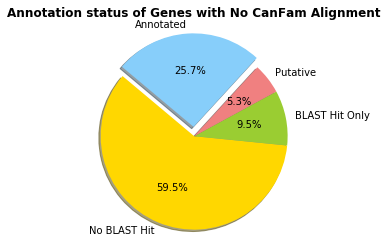

In [29]:
NoB2GO, BlastOnly, MappedOnly, Annotated = 0,0,0,0
for gene in geneDict.keys():
    if 'No hit' in geneDict[gene]['CanFam_AlignmentStatus']:
        if geneDict[gene]['B2GO_Status'] == 'No BLAST Hit':
            NoB2GO += 1
            continue
        if geneDict[gene]['B2GO_Status'] == 'BLAST only':
            BlastOnly += 1
            continue
        if geneDict[gene]['B2GO_Status'] == 'Putative':
            MappedOnly += 1
            continue
        if geneDict[gene]['B2GO_Status'] == 'Annotated':
            Annotated += 1
            print(geneDict[gene]['B2GO_GeneSymbol'],geneDict[gene]['B2GO_TopHitDesc'],geneDict[gene]['Zoey_Chrom'],geneDict[gene]['Zoey_Start'],geneDict[gene]['Zoey_End'])
            print('%i\t%i aa' % (geneDict[gene]['Kalisto_LibrariesExpression'],geneDict[gene]['GeneLength']))
            continue
        else:
            print('ERROR: What else is there?')
            print(gene,geneDict[gene])
    if 'No hit' in geneDict[gene]['CanFam_AlignmentStatus'] and geneDict[gene]['B2GO_Status'] == 'Annotated' and geneDict[gene]['GeneLength'] > 400 and geneDict[gene]['Kalisto_LibrariesExpression'] > 30:
        print('%s   %s:%s-%s' % (gene,geneDict[gene]['Zoey_Chrom'],geneDict[gene]['Zoey_Start'],geneDict[gene]['Zoey_End']))
print('count sum = ', (NoB2GO + BlastOnly + MappedOnly+ Annotated))
            
#Make pie chart
labels = 'No BLAST Hit', 'BLAST Hit Only', 'Putative', 'Annotated'
sizes = [NoB2GO, BlastOnly, MappedOnly, Annotated]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0, 0, 0, 0.1)  # explode 4th slice
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Annotation status of Genes with No CanFam Alignment', fontweight='bold') 
plt.axis('equal')
plt.show()

### PARTIAL HITS TO CANFAM

alpha-1B adrenergic receptor chr4 50920160 50968213
transcription factor Sp9 chr36 18614094 18616859
protein kinase C delta-binding protein chr21 29805012 29811161
brorin chr18 1288975 1289830
centromere V chr5 39650360 39664919
zinc finger CCHC domain-containing protein 2 chr1 14231252 14289429
zinc finger protein with KRAB and SCAN domains 7 isoform X1 chr23 1899285 1914394
hairy/enhancer-of-split related with YRPW motif protein 2 chr1 64768956 64782639
RING finger 186-like chr5 32839144 32843055
chromatin accessibility complex protein 1 chr13 35264730 35270622
ras and Rab interactor 3 chr8 1692965 1797283
cytoplasmic tRNA 2-thiolation protein 1 chr1 105976094 105983308
NCK-interacting protein with SH3 domain isoform X2 chr20 40162574 40172905
interferon alpha-inducible 27 2 chr8 63109620 63114444
trinucleotide repeat-containing gene 18 chr6 12466694 12553799
P protein chr3 32155126 32595953
zinc transporter ZIP5 chr10 532914 548481
latent-transforming growth factor beta-binding prot

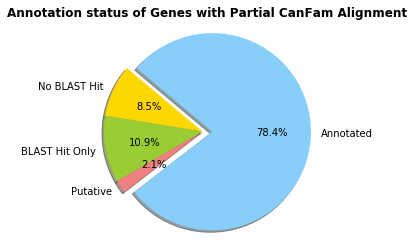

In [24]:
NoB2GO, BlastOnly, MappedOnly, Annotated = 0,0,0,0
for gene in geneDict.keys():
    if 'Partial' in geneDict[gene]['CanFam_AlignmentStatus']:
        if geneDict[gene]['B2GO_Status'] == 'No BLAST Hit':
            NoB2GO += 1
            continue
        if geneDict[gene]['B2GO_Status'] == 'BLAST only':
            BlastOnly += 1
            continue
        if geneDict[gene]['B2GO_Status'] == 'Putative':
            MappedOnly += 1
            continue
        if geneDict[gene]['B2GO_Status'] == 'Annotated':
            Annotated += 1
            print(geneDict[gene]['B2GO_TopHitDesc'],geneDict[gene]['Zoey_Chrom'],geneDict[gene]['Zoey_Start'],geneDict[gene]['Zoey_End'])
            continue
        else:
            print('ERROR: What else is there?')
        print(gene,geneDict[gene])
print('count sum = ', (NoB2GO + BlastOnly + MappedOnly+ Annotated))
            
#Make pie chart
labels = 'No BLAST Hit', 'BLAST Hit Only', 'Putative', 'Annotated'
sizes = [NoB2GO, BlastOnly, MappedOnly, Annotated]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0, 0, 0, 0.1)  # explode 4th slice
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Annotation status of Genes with Partial CanFam Alignment', fontweight='bold') 
plt.axis('equal')
plt.show()